<a href="https://colab.research.google.com/github/ccc-frankfurt/Practical_ML_SS21/blob/main/week08/Autoencoders_MLPR_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders in PyTorch
Here, we extend our previous MLP and CNN PyTorch Fashion-MNIST example to the unsupervised learning scenario with autoencoders. 

Before starting the notebook you should make sure that your runtime uses GPU acceleration. You can find the corresponding option under *runtime* and then *change runtime type*.

In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset class in PyTorch
Our dataset loader essentially remains the same as before. We do not remove the labels even though we do not need them for training of autoencoders. We will however use a small subset of the labels for semi-supervised training towards the end of the notebook. 

In [2]:
import os
import struct
import gzip
import errno
import torch.utils.data
import torchvision.datasets as datasets


class FashionMNIST:
    """
    Fashion MNIST dataset featuring gray-scale 28x28 images of
    fashion items belonging to ten different classes.
    Dataloader adapted from MNIST.
    We do not define __getitem__ and __len__ in this class
    as we are using torch.utils.data.TensorDataSet which
    already implements these methods.

    Parameters:
        args (dict): Dictionary of (command line) arguments.
            Needs to contain batch_size (int) and workers(int).
        is_gpu (bool): True if CUDA is enabled.
            Sets value of pin_memory in DataLoader.

    Attributes:
        trainset (torch.utils.data.TensorDataset): Training set wrapper.
        valset (torch.utils.data.TensorDataset): Validation set wrapper.
        train_loader (torch.utils.data.DataLoader): Training set loader with shuffling.
        val_loader (torch.utils.data.DataLoader): Validation set loader.
    """

    def __init__(self, is_gpu, batch_size, workers):
        self.path = os.path.expanduser('datasets/FashionMNIST')
        self.__download()

        self.trainset, self.valset = self.get_dataset()

        self.train_loader, self.val_loader = self.get_dataset_loader(batch_size, workers, is_gpu)

        self.val_loader.dataset.class_to_idx = {'T-shirt/top': 0,
                                                'Trouser': 1,
                                                'Pullover': 2,
                                                'Dress': 3,
                                                'Coat': 4,
                                                'Sandal': 5,
                                                'Shirt': 6,
                                                'Sneaker': 7,
                                                'Bag': 8,
                                                'Ankle boot': 9}

    def __check_exists(self):
        """
        Checks if dataset has already been downloaded

        Returns:
             bool: True if downloaded dataset has been found
        """

        return os.path.exists(os.path.join(self.path, 'train-images-idx3-ubyte.gz')) and \
               os.path.exists(os.path.join(self.path, 'train-labels-idx1-ubyte.gz')) and \
               os.path.exists(os.path.join(self.path, 't10k-images-idx3-ubyte.gz')) and \
               os.path.exists(os.path.join(self.path, 't10k-labels-idx1-ubyte.gz'))

    def __download(self):
        """
        Downloads the Fashion-MNIST dataset from the web if dataset
        hasn't already been downloaded.
        """

        from six.moves import urllib

        if self.__check_exists():
            return

        print("Downloading FashionMNIST dataset")
        urls = [
            'https://cdn.rawgit.com/zalandoresearch/fashion-mnist/ed8e4f3b/data/fashion/train-images-idx3-ubyte.gz',
            'https://cdn.rawgit.com/zalandoresearch/fashion-mnist/ed8e4f3b/data/fashion/train-labels-idx1-ubyte.gz',
            'https://cdn.rawgit.com/zalandoresearch/fashion-mnist/ed8e4f3b/data/fashion/t10k-images-idx3-ubyte.gz',
            'https://cdn.rawgit.com/zalandoresearch/fashion-mnist/ed8e4f3b/data/fashion/t10k-labels-idx1-ubyte.gz',
        ]

        # download files
        try:
            os.makedirs(self.path)
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        for url in urls:
            print('Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.path, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())

        print('Done!')

    def __get_fashion_mnist(self, path, kind='train'):
        """
        Load Fashion-MNIST data

        Parameters:
            path (str): Base directory path containing .gz files for
                the Fashion-MNIST dataset
            kind (str): Accepted types are 'train' and 't10k' for
                training and validation set stored in .gz files

        Returns:
            numpy.array: images, labels
        """

        labels_path = os.path.join(path,
                                   '%s-labels-idx1-ubyte.gz'
                                   % kind)
        images_path = os.path.join(path,
                                   '%s-images-idx3-ubyte.gz'
                                   % kind)

        with gzip.open(labels_path, 'rb') as lbpath:
            struct.unpack('>II', lbpath.read(8))
            labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

        with gzip.open(images_path, 'rb') as imgpath:
            struct.unpack(">IIII", imgpath.read(16))
            images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 784)

        return images, labels

    def get_dataset(self):
        """
        Loads and wraps training and validation datasets

        Returns:
             torch.utils.data.TensorDataset: trainset, valset
        """

        x_train, y_train = self.__get_fashion_mnist(self.path, kind='train')
        x_val, y_val = self.__get_fashion_mnist(self.path, kind='t10k')

        # This is new with respect to our previous data loader
        # convert to torch tensors in range [0, 1]
        x_train = torch.from_numpy(x_train).float() / 255
        y_train = torch.from_numpy(y_train).long()
        x_val = torch.from_numpy(x_val).float() / 255
        y_val = torch.from_numpy(y_val).long()

        # resize flattened array of images for input to a CNN
        # we use the in-place variant of the resize function here
        x_train.resize_(x_train.size(0), 1, 28, 28)
        x_val.resize_(x_val.size(0), 1, 28, 28)

        # TensorDataset wrapper
        trainset = torch.utils.data.TensorDataset(x_train, y_train)
        valset = torch.utils.data.TensorDataset(x_val, y_val)

        return trainset, valset

    def get_dataset_loader(self, batch_size, workers, is_gpu):
        """
        Defines the dataset loader for wrapped dataset

        Parameters:
            batch_size (int): Defines the batch size in data loader
            workers (int): Number of parallel threads to be used by data loader
            is_gpu (bool): True if CUDA is enabled so pin_memory is set to True

        Returns:
             torch.utils.data.TensorDataset: trainset, valset
        """

        # multi-threaded data loaders
        train_loader = torch.utils.data.DataLoader(self.trainset, batch_size=batch_size, shuffle=True,
                                                   num_workers=workers, pin_memory=is_gpu, sampler=None)
        test_loader = torch.utils.data.DataLoader(self.valset, batch_size=batch_size, shuffle=True,
                                                  num_workers=workers, pin_memory=is_gpu, sampler=None)

        return train_loader, test_loader


Let's load the data and set the device to use. 

In [3]:
# set a boolean flag that indicates whether a cuda capable GPU is available 
# we will need this for transferring our tensors to the device and 
# for persistent memory in the data loader
is_gpu = torch.cuda.is_available()
print("GPU is available:", is_gpu)
print("If you are receiving False, try setting your runtime to GPU")

# set the device to cuda if a GPU is available
device = torch.device("cuda" if is_gpu else "cpu")

# in contrast to our MLP from scratch notebook, we need to set the batch size already now
# this is because our data loader now requires it.
batch_size = 128
# we also set the amount of workers, i.e. parallel threads to use in our data loader
workers = 2

# We can now instantiate our dataset class 
dataset = FashionMNIST(is_gpu, batch_size, workers)

GPU is available: True
If you are receiving False, try setting your runtime to GPU
Done!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)


### The MLP based Autoencoder model in PyTorch
We extend our 2 hidden layer MLP to an autoencoder by adding a decoder. For convenience we let the decoder architecture (number and amount of units) remain the same as the encoder. Note that however, this is not necessary and could technically be different. 

Suitable hidden-layer sizes for this task could be 100 and 100, like in our last notebook. 
Because we are using an optimized GPU implementation, you are welcome and should try larger sizes to see the impact of neural network size (capacity) on our task!

From previous weeks we know that there is three ways to build our model: 

    1. Defining an nn.Sequential() container for encoder and decoder and calling them in the forward function.
    2. Defining all the layers and writing an encode and decode function that specify the execution of the individual layers. The encode and decode functions get called in the forward pass.
    3. Defining the layers and writing all the calls directly into the forward function. While this is a valid model, we strongly recommend against this, as for more involved models this gets more complicated to read and understand.  
    
Here we will use option 1 and we will see how to implement version 2 for the variational autoencoder next week.

In [4]:
class AE_MLP(nn.Module):
    def __init__(self, img_size, latent_dim):
        super(AE_MLP, self).__init__()
        
        self.img_size = img_size
        
        # encoder
        self.encoder = nn.Sequential(nn.Linear(img_size * img_size, 100),
                                     nn.ReLU(True),
                                     nn.Linear(100, 100),
                                     nn.ReLU(True),
                                     nn.Linear(100, latent_dim),
                                     nn.ReLU(True))
        
        # decoder
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 100),
                                     nn.ReLU(True),
                                     nn.Linear(100, 100),
                                     nn.ReLU(True),
                                     nn.Linear(100, img_size * img_size))

    def forward(self, x):
        # The view flattens the data to a vector (the representation needed by the MLP)
        x = x.view(-1, self.img_size * self.img_size)
        z = self.encoder(x)
        x = self.decoder(z)
        # because the MLP has flattened, we now view the output back as an image
        x = x.view(-1, 1, self.img_size, self.img_size)
        return x

### Defining optimization criterion and optimizer
Similarly to our supervised sample we can now use the negative log-likelihood as a loss function and optimize it with a binary cross entropy to measure the reconstruction loss between input and output. 

As with the CrossEntropy function before PyTorch already implements a Sigmioid function in the BCEWithLogitsLoss and combines it directly in the loss! Alternatively we could just use the BCE loss function and add the sigmoid to the end of our decoder by hand or stick with a mean squared error MSELoss() function.

This time we will use an adaptive optimizer that we have learned about in the first lecture, called Adam: https://arxiv.org/abs/1412.6980. A typical learning rate for Adam will be 1e-4 or 1e-3 as the step size is adaptive.

In [5]:
# Define optimizer and loss function (criterion)
img_size = 28
# the latent dimension defines how much the input will be compressed, 
# this is a hyper-parameter.
latent_dim = 20

# create an instance of the MLP based autoencoder and transfer the model to the device.
# Note that we do not necessarily need any custom weight initialization as PyTorch
# already uses the initialization schemes that we have previously learned about internally. 
model = AE_MLP(img_size, latent_dim).to(device)
# we can also print the model architecture
print(model)

# set the loss function
criterion = nn.BCEWithLogitsLoss().to(device)

# we can use advanced stochastic gradient descent algorithms 
# with regularization (weight-decay) or momentum
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

AE_MLP(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=20, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=784, bias=True)
  )
)


### Monitoring losses 

We will reuse our function to monitor loss averages. As we are now conducting unsupervised learning, we no longer have any function calculating accuracies.

In [6]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Training function
The training function needs to loop through the entire dataset in steps of mini-batches (for SGD). For each mini-batch the output of the model and losses are calculated and a *backward* pass is done to calculate gradients and an *optimizer step* is done in order to do the respective update to the model's weights. 

When the entire dataset has been processed once, one epoch of the training has been conducted. It is common to shuffle the dataset after each epoch. In contrast to our previous notebook from scratch, in this implementation this is handled by the "sampler" of the dataset loader. 

In [7]:
def train(train_loader, model, criterion, optimizer, device):
    """
    Trains/updates the model for one epoch on the training dataset.

    Parameters:
        train_loader (torch.utils.data.DataLoader): The trainset dataloader
        model (torch.nn.module): Model to be trained
        criterion (torch.nn.criterion): Loss function
        optimizer (torch.optim.optimizer): optimizer instance like SGD or Adam
        device (string): cuda or cpu
    """

    # create an instance of the average meter to track losses
    losses = AverageMeter()

    # switch to train mode
    model.train()

    # iterate through the dataset loader
    # we can now discard the labels returned by our old data loader as we no longer need them
    for i, (inp, _) in enumerate(train_loader):
        # transfer inputs and targets to the GPU (if it is available)
        inp = inp.to(device)
        target = inp
        
        # you can make your autoencoder a denoising autoencoder by 
        # adding noise to the input, but not to the target!
        # To test the denoising autoencoder, uncomment the line below, 
        # where we add a small Gaussian noise to the original images
        #inp = inp + torch.randn(inp.size()).to(device) * 0.1
        
        # compute output, i.e. the model forward
        output = model(inp)
        
        # calculate the loss
        loss = criterion(output, target)

        # record loss
        losses.update(loss.item(), inp.size(0))

        # compute gradient and do the SGD step
        # we reset the optimizer with zero_grad to "flush" former gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print the loss every 100 mini-batches
        if i % 100 == 0:
            print('Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(loss=losses))

### Validation function
Validation is similar to the training loop, but on a separate dataset with the exception that no update to the weights is performed. This way we can monitor the generalization ability of our model and check whether it is overfitting (memorizing) the training dataset.  

In [8]:
def validate(val_loader, model, criterion, device):
    """
    Evaluates/validates the model

    Parameters:
        val_loader (torch.utils.data.DataLoader): The validation or testset dataloader
        model (torch.nn.module): Model to be evaluated/validated
        criterion (torch.nn.criterion): Loss function
        device (string): cuda or cpu
    """

    # create an instance of the average meter to track losses
    losses = AverageMeter()

    # switch to evaluate mode 
    # (this would be important for e.g. dropout where stochasticity shouldn't be applied during testing)
    model.eval()

    # avoid computation of gradients and necessary storing of intermediate layer activations
    with torch.no_grad():
        # iterate through the dataset loader
        # we can now discard the labels returned by our old data loader as we no longer need them
        for i, (inp, _) in enumerate(val_loader):
            # transfer to device
            inp = inp.to(device)
            target = inp

            # compute output
            output = model(inp)

            # compute loss
            loss = criterion(output, target)

            # record loss
            losses.update(loss.item(), inp.size(0))
            
            # visualize only one full mini-batch
            if i == (len(val_loader) - 2):
                # let us also visualize the last mini-batch of images and reconstructions
                # we can use the torchvision utility to make grids of images
                print("Original images")
                imgs = torchvision.utils.make_grid(inp.cpu(), nrow=int(math.sqrt(inp.size(0))), padding=5)
                npimgs = imgs.numpy()
                # when using matplotlib the color channels are expected to be in the third 
                # instead of the first dimension -> tranpose
                plt.imshow(np.transpose(npimgs, (1,2,0)))
                plt.show()
                
                # do the same for reconstructions
                print("Reconstructed images")
                recons = torchvision.utils.make_grid(torch.sigmoid(output).cpu(), nrow=int(math.sqrt(inp.size(0))), padding=5)
                npimgs = recons.numpy()
                plt.imshow(np.transpose(npimgs, (1,2,0)))
                plt.show()


    print('Loss {loss.val:.4f} ({loss.avg:.4f})'.format(loss=losses))

### Running the training of the model
Let's optimize this model for 20 epochs and check at every epoch how we are doing on our validation set. As defined above, we also visualize some images and their reconstructions.

Depending on your model definition and optimizer you might experience over-fitting!

EPOCH: 1
TRAIN
Loss 0.6940 (0.6940)	
Loss 0.5838 (0.6612)	
Loss 0.5029 (0.5943)	
Loss 0.4833 (0.5605)	
Loss 0.4305 (0.5326)	
VALIDATION
Original images


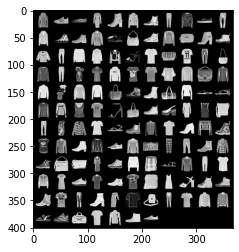

Reconstructed images


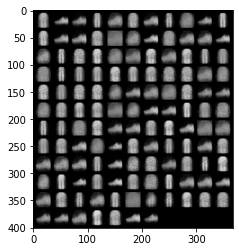

Loss 0.4060 (0.4062)
EPOCH: 2
TRAIN
Loss 0.4018 (0.4018)	
Loss 0.3786 (0.3950)	
Loss 0.3784 (0.3872)	
Loss 0.3694 (0.3823)	
Loss 0.3531 (0.3779)	
VALIDATION
Original images


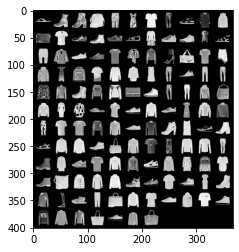

Reconstructed images


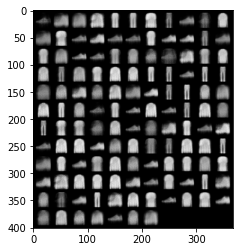

Loss 0.3483 (0.3601)
EPOCH: 3
TRAIN
Loss 0.3679 (0.3679)	
Loss 0.3689 (0.3579)	
Loss 0.3606 (0.3574)	
Loss 0.3428 (0.3558)	
Loss 0.3502 (0.3544)	
VALIDATION
Original images


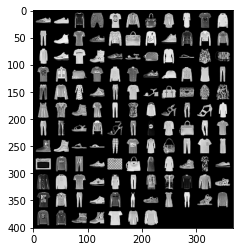

Reconstructed images


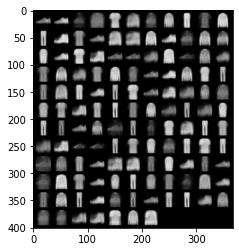

Loss 0.3074 (0.3473)
EPOCH: 4
TRAIN
Loss 0.3531 (0.3531)	
Loss 0.3446 (0.3460)	
Loss 0.3361 (0.3451)	
Loss 0.3372 (0.3441)	
Loss 0.3402 (0.3427)	
VALIDATION
Original images


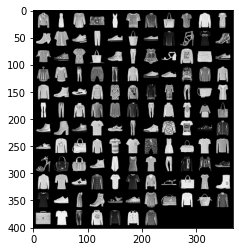

Reconstructed images


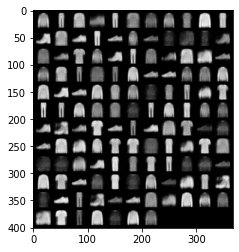

Loss 0.3605 (0.3360)
EPOCH: 5
TRAIN
Loss 0.3147 (0.3147)	
Loss 0.3325 (0.3351)	
Loss 0.3216 (0.3349)	
Loss 0.3420 (0.3340)	
Loss 0.3374 (0.3332)	
VALIDATION
Original images


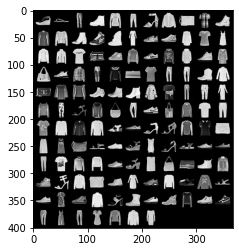

Reconstructed images


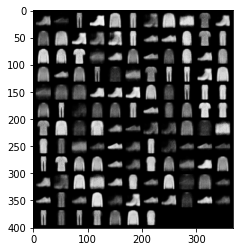

Loss 0.3131 (0.3300)
EPOCH: 6
TRAIN
Loss 0.3164 (0.3164)	
Loss 0.3319 (0.3296)	
Loss 0.3219 (0.3286)	
Loss 0.3228 (0.3286)	
Loss 0.3383 (0.3285)	
VALIDATION
Original images


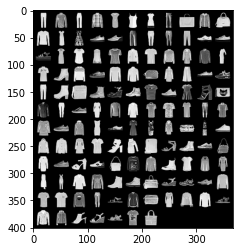

Reconstructed images


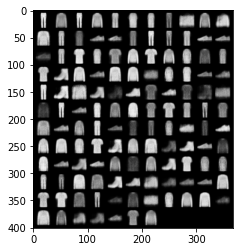

Loss 0.3105 (0.3266)
EPOCH: 7
TRAIN
Loss 0.3332 (0.3332)	
Loss 0.3305 (0.3269)	
Loss 0.3291 (0.3261)	
Loss 0.3223 (0.3258)	
Loss 0.3215 (0.3255)	
VALIDATION
Original images


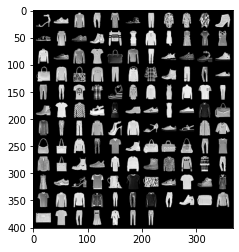

Reconstructed images


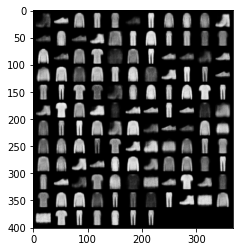

Loss 0.2762 (0.3237)
EPOCH: 8
TRAIN
Loss 0.3105 (0.3105)	
Loss 0.3445 (0.3247)	
Loss 0.3270 (0.3230)	
Loss 0.3177 (0.3223)	
Loss 0.3204 (0.3224)	
VALIDATION
Original images


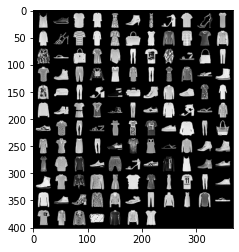

Reconstructed images


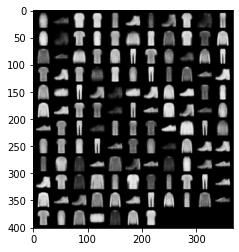

Loss 0.3733 (0.3205)
EPOCH: 9
TRAIN
Loss 0.3200 (0.3200)	
Loss 0.3277 (0.3196)	
Loss 0.3119 (0.3200)	
Loss 0.3133 (0.3194)	
Loss 0.2863 (0.3190)	
VALIDATION
Original images


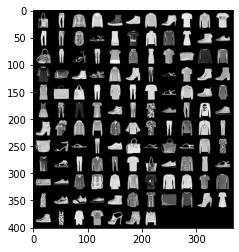

Reconstructed images


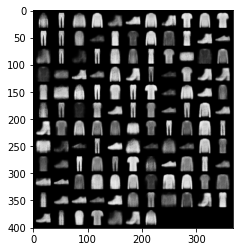

Loss 0.3285 (0.3171)
EPOCH: 10
TRAIN
Loss 0.3332 (0.3332)	
Loss 0.3246 (0.3165)	
Loss 0.3251 (0.3166)	
Loss 0.3061 (0.3162)	
Loss 0.3201 (0.3160)	
VALIDATION
Original images


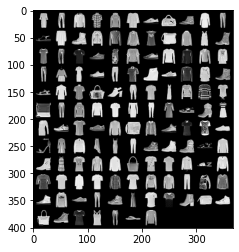

Reconstructed images


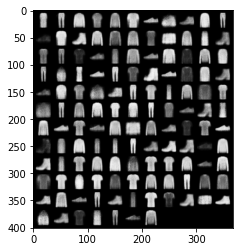

Loss 0.2750 (0.3139)
EPOCH: 11
TRAIN
Loss 0.2983 (0.2983)	
Loss 0.3228 (0.3133)	
Loss 0.3084 (0.3125)	
Loss 0.3120 (0.3129)	
Loss 0.3310 (0.3126)	
VALIDATION
Original images


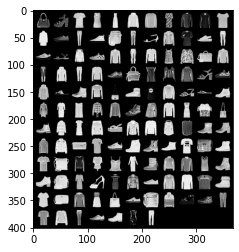

Reconstructed images


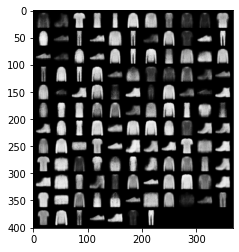

Loss 0.3332 (0.3113)
EPOCH: 12
TRAIN
Loss 0.3305 (0.3305)	
Loss 0.3208 (0.3125)	
Loss 0.2965 (0.3116)	
Loss 0.3034 (0.3110)	
Loss 0.3010 (0.3105)	
VALIDATION
Original images


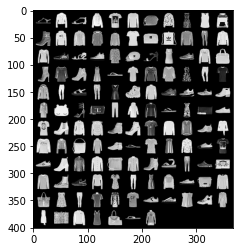

Reconstructed images


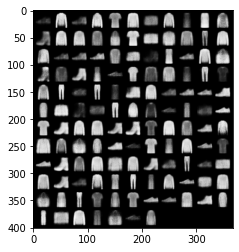

Loss 0.2947 (0.3095)
EPOCH: 13
TRAIN
Loss 0.3080 (0.3080)	
Loss 0.3254 (0.3089)	
Loss 0.3019 (0.3094)	
Loss 0.3050 (0.3089)	
Loss 0.3223 (0.3088)	
VALIDATION
Original images


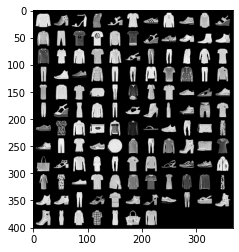

Reconstructed images


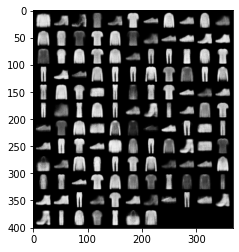

Loss 0.3055 (0.3083)
EPOCH: 14
TRAIN
Loss 0.3242 (0.3242)	
Loss 0.3151 (0.3087)	
Loss 0.3075 (0.3084)	
Loss 0.3105 (0.3085)	
Loss 0.3148 (0.3080)	
VALIDATION
Original images


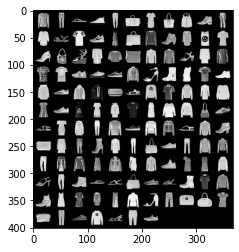

Reconstructed images


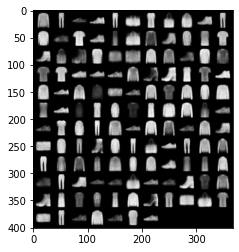

Loss 0.3082 (0.3073)
EPOCH: 15
TRAIN
Loss 0.2998 (0.2998)	
Loss 0.3128 (0.3082)	
Loss 0.3146 (0.3083)	
Loss 0.3017 (0.3077)	
Loss 0.3018 (0.3071)	
VALIDATION
Original images


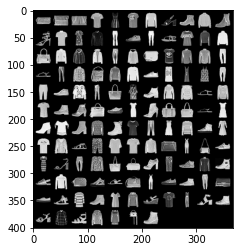

Reconstructed images


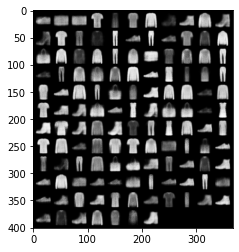

Loss 0.3115 (0.3066)
EPOCH: 16
TRAIN
Loss 0.2919 (0.2919)	
Loss 0.3055 (0.3059)	
Loss 0.3101 (0.3064)	
Loss 0.3219 (0.3067)	
Loss 0.3073 (0.3065)	
VALIDATION
Original images


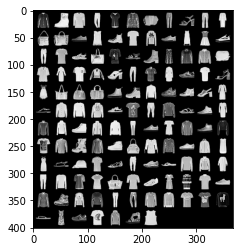

Reconstructed images


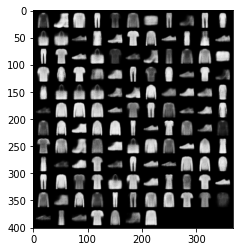

Loss 0.3062 (0.3058)
EPOCH: 17
TRAIN
Loss 0.2991 (0.2991)	
Loss 0.2974 (0.3061)	
Loss 0.3085 (0.3055)	
Loss 0.3008 (0.3055)	
Loss 0.3011 (0.3056)	
VALIDATION
Original images


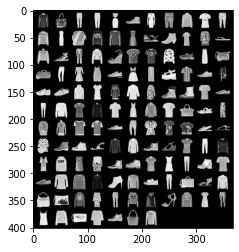

Reconstructed images


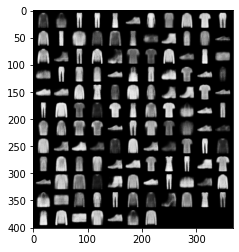

Loss 0.3107 (0.3052)
EPOCH: 18
TRAIN
Loss 0.3028 (0.3028)	
Loss 0.3030 (0.3051)	
Loss 0.3069 (0.3053)	
Loss 0.3062 (0.3054)	
Loss 0.2980 (0.3052)	
VALIDATION
Original images


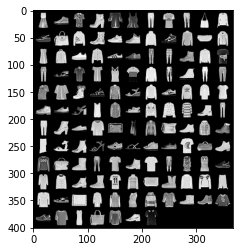

Reconstructed images


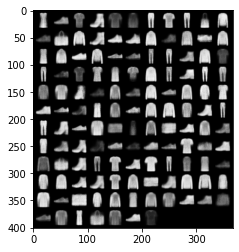

Loss 0.2897 (0.3044)
EPOCH: 19
TRAIN
Loss 0.2943 (0.2943)	
Loss 0.2946 (0.3043)	
Loss 0.2930 (0.3041)	
Loss 0.2944 (0.3041)	
Loss 0.3084 (0.3040)	
VALIDATION
Original images


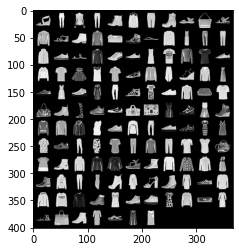

Reconstructed images


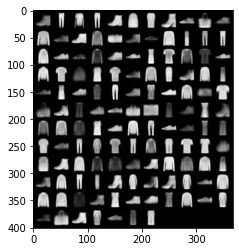

Loss 0.2873 (0.3037)
EPOCH: 20
TRAIN
Loss 0.3026 (0.3026)	
Loss 0.3176 (0.3038)	
Loss 0.2964 (0.3037)	
Loss 0.2988 (0.3039)	
Loss 0.3100 (0.3036)	
VALIDATION
Original images


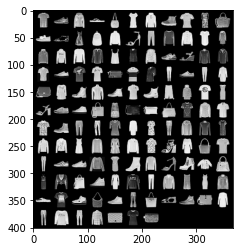

Reconstructed images


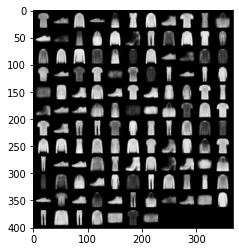

Loss 0.3204 (0.3030)


In [9]:
total_epochs = 20
for epoch in range(total_epochs):
    print("EPOCH:", epoch + 1)
    print("TRAIN")
    train(dataset.train_loader, model, criterion, optimizer, device)
    print("VALIDATION")
    validate(dataset.val_loader, model, criterion, device)

## From unsupervised learning to semi-supervised learning
Now that we have seen that our model was able to successfuly learn how to compress and decompress the data in a completely unsupervised fashion, we can try to make use of the learned representations

### Making use of learned representations
Assume that we have a dataset where a majority of images is not labelled, so we can not directly use supervised end-to-end learning as encountered in the last weeks. However, our autoencoder's encoder learns a feature description that best described the seen dataset. 

We can use the feature representation of our autoencoder's encoder and now simply train a classifier (e.g. a simple linear combination) on top with the few labels that we have. This way the classifier can learn how the autoencoder's extracted generic feature representations map to specific classes.

For this purpose let us do the following four things:

    1. Let us again define an accuracy function to measure our classification progress
    2. Let us define supervised training and validation functions, where we now first compute the already trained autoencder's decoder and then compute a classifier
    3. Let us define a single layer linear classifier 
    4. Let us define a new optimizer instance for only the classifier, i.e. the weights of the autoencoder remain fixed.
    5. Let us take half of the validation data (i.e. only 5% of the entire datasets) to train the supervised scenario with few labels and test on the remaining 50% of the validation set.

### Semi-supervised training and validation functions


In [10]:
def accuracy(output, target, topk=(1,)):
    """
    Evaluates a model's top k accuracy

    Parameters:
        output (torch.autograd.Variable): model output
        target (torch.autograd.Variable): ground-truths/labels
        topk (list): list of integers specifying top-k precisions
            to be computed

    Returns:
        float: percentage of correct predictions
    """

    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [11]:
def train_supervised(train_loader, encoder, img_size, classifier, criterion, optimizer, device):
    """
    Trains/updates the classifier for one epoch on the training dataset.

    Parameters:
        train_loader (torch.utils.data.DataLoader): The trainset dataloader
        encoder (torch.nn.module): Fixed weight encoder
        img_size (int): Spatial size of the input images
        classifier (torch.nn.module): Classifier to be trained
        criterion (torch.nn.criterion): Loss function
        optimizer (torch.optim.optimizer): optimizer instance like SGD or Adam
        device (string): cuda or cpu
    """

    # create an instance of the average meter to track losses
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    # set the encoder to evaluate mode as it isn't trained 
    # (this would be important for e.g. dropout where stochasticity shouldn't be applied during testing)
    encoder.eval()
    classifier.train()

    # iterate through the dataset loader
    for i, (inp, target) in enumerate(train_loader):
        # transfer inputs and targets to the GPU (if it is available)
        inp = inp.to(device)
        target = target.to(device)
        
        # compute output, i.e. the model forward
        # first flatten the image and calculate the static autoencoder's encoder
        inp = inp.view(-1, img_size * img_size)
        embedding = encoder(inp)
        # then compute the classifier on the obtained embedding
        output = classifier(embedding)
        
        # calculate the loss
        loss = criterion(output, target)

        # measure accuracy and record loss and accuracy
        prec1, _ = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), inp.size(0))
        top1.update(prec1.item(), inp.size(0))

        # compute gradient and do the SGD step
        # we reset the optimizer with zero_grad to "flush" former gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print the loss every 100 mini-batches
        if i % 100 == 0:
            print('Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                   loss=losses, top1=top1))

In [12]:
def validate_supervised(val_loader, encoder, img_size, classifier, criterion, device):
    """
    Evaluates the model

    Parameters:
        val_loader (torch.utils.data.DataLoader): The valset dataloader
        encoder (torch.nn.module): Fixed weight encoder
        img_size (int): Spatial size of the input images
        classifier (torch.nn.module): Classifier to be trained
        criterion (torch.nn.criterion): Loss function
        device (string): cuda or cpu
    """

    # create instances of the average meter to track losses and accuracies
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode 
    # (this would be important for e.g. dropout where stochasticity shouldn't be applied during testing)
    encoder.eval()
    classifier.eval()

    # avoid computation of gradients and necessary storing of intermediate layer activations
    with torch.no_grad():
        # iterate through the dataset loader
        for i, (inp, target) in enumerate(val_loader):
            # transfer to device
            inp = inp.to(device)
            target = target.to(device)

            # compute output, i.e. the model forward
            # first flatten the image and calculate the static autoencoder's encoder
            inp = inp.view(-1, img_size * img_size)
            embedding = encoder(inp)
            # then compute the classifier on the obtained embedding
            output = classifier(embedding)

            # compute loss
            loss = criterion(output, target)

            # measure accuracy and record loss and accuracy
            prec1, _ = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), inp.size(0))
            top1.update(prec1.item(), inp.size(0))

    print(' * Validation accuracy: Prec@1 {top1.avg:.3f} '.format(top1=top1))

#### Semi-supervised optimization

In [13]:
n_classes = len(dataset.val_loader.dataset.class_to_idx)

# Define the single linear layer classifier that maps from the encoder's latent 
# embedding to the amount of classes. 
classifier = nn.Linear(latent_dim, n_classes).to(device)

# Let us split the validation dataset into two separate sets, each containing 
# 50% of the data to use for supervised learning and validation. 
# We can use the torch.utils.data.random_split function for this purpose.
labeled_train_set, labeled_val_set = torch.utils.data.random_split(dataset.valset, [int(0.5 * len(dataset.valset)), int(0.5 * len(dataset.valset))])
supervised_train_loader = torch.utils.data.DataLoader(labeled_train_set, batch_size=batch_size, shuffle=True, 
                                                      num_workers=workers, pin_memory=is_gpu, sampler=None)
supervised_test_loader = torch.utils.data.DataLoader(labeled_val_set, batch_size=batch_size, shuffle=False, 
                                                     num_workers=workers, pin_memory=is_gpu, sampler=None)

# set the supervised loss function
criterion = nn.CrossEntropyLoss().to(device)

# create the optimizer. 
# IMPORTANT: we will only optimize the classifier parameters here and keep 
# the encoder parameters fixed to see how far we can get just by fine-tuning
# on a few labels. 
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

total_epochs = 40
for epoch in range(total_epochs):
    print("EPOCH:", epoch + 1)
    print("TRAIN")
    train_supervised(supervised_train_loader, model.encoder, img_size,
                     classifier, criterion, optimizer, device)
    print("VALIDATION")
    validate_supervised(supervised_test_loader, model.encoder, img_size,
                        classifier, criterion, device)

EPOCH: 1
TRAIN
Loss 10.8067 (10.8067)	Prec@1 7.812 (7.812)
VALIDATION
 * Validation accuracy: Prec@1 19.940 
EPOCH: 2
TRAIN
Loss 4.4931 (4.4931)	Prec@1 14.844 (14.844)
VALIDATION
 * Validation accuracy: Prec@1 35.000 
EPOCH: 3
TRAIN
Loss 2.2541 (2.2541)	Prec@1 38.281 (38.281)
VALIDATION
 * Validation accuracy: Prec@1 38.100 
EPOCH: 4
TRAIN
Loss 1.8574 (1.8574)	Prec@1 36.719 (36.719)
VALIDATION
 * Validation accuracy: Prec@1 45.500 
EPOCH: 5
TRAIN
Loss 1.5231 (1.5231)	Prec@1 32.031 (32.031)
VALIDATION
 * Validation accuracy: Prec@1 50.540 
EPOCH: 6
TRAIN
Loss 1.3458 (1.3458)	Prec@1 49.219 (49.219)
VALIDATION
 * Validation accuracy: Prec@1 54.720 
EPOCH: 7
TRAIN
Loss 1.0658 (1.0658)	Prec@1 57.031 (57.031)
VALIDATION
 * Validation accuracy: Prec@1 59.500 
EPOCH: 8
TRAIN
Loss 1.1546 (1.1546)	Prec@1 57.031 (57.031)
VALIDATION
 * Validation accuracy: Prec@1 61.040 
EPOCH: 9
TRAIN
Loss 1.0014 (1.0014)	Prec@1 60.938 (60.938)
VALIDATION
 * Validation accuracy: Prec@1 62.120 
EPOCH: 10
TRAIN
Los

### The pre-training clearly helped us to use only few labels to map the existing encoding to class concepts. However, our results seem to be much worse than what we likely expected. On the other hand, we have just used 5% of the labels of the dataset. 

## Moving from MLP to CNN
We will now implement the autoencoder for our previously used convolutional neural network. For downsampling operations such as pooling, we can analogously implement upsampling in the decoder. For strided convolution, we could add stride to the transposed version.

As previously mentioned we will implement the model through individual functions instead of nn.Sequential containers now. 

In [14]:
class AE_CNN(nn.Module):
    def __init__(self):
        super(AE_CNN, self).__init__()
        
        self.encoder = nn.Sequential(nn.Conv2d(1, 64, 5), # input features, output features, kernel size 
                                     nn.ReLU(True), 
                                     nn.MaxPool2d(2, 2), # kernel size, stride 
                                     nn.Conv2d(64, 128, 5), # input features, output features, kernel size 
                                     nn.ReLU(True), 
                                     nn.MaxPool2d(2, 2)) # kernel size, stride
        
        self.decoder = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'), 
                                     nn.ConvTranspose2d(128, 64, 5), 
                                     nn.ReLU(True), 
                                     nn.Upsample(scale_factor=2, mode='nearest'), 
                                     nn.ConvTranspose2d(64, 1, 5))
    
    def forward(self, x):
        h = self.encoder(x)
        x = self.decoder(h)
        return x

AE_CNN(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): Upsample(scale_factor=2.0, mode=nearest)
    (4): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(1, 1))
  )
)
EPOCH: 1
TRAIN
Loss 0.6803 (0.6803)	


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loss 0.3497 (0.4205)	
Loss 0.3099 (0.3742)	
Loss 0.3154 (0.3522)	
Loss 0.2918 (0.3387)	
VALIDATION
Original images


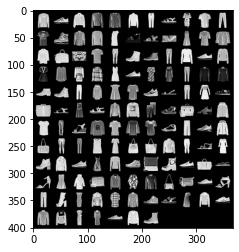

Reconstructed images


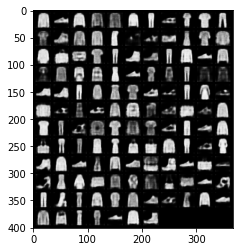

Loss 0.3088 (0.2935)
EPOCH: 2
TRAIN
Loss 0.2902 (0.2902)	
Loss 0.3059 (0.2916)	
Loss 0.2847 (0.2900)	
Loss 0.2825 (0.2890)	
Loss 0.2739 (0.2874)	
VALIDATION
Original images


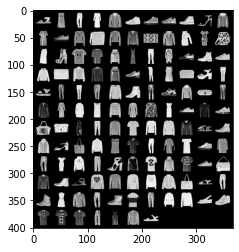

Reconstructed images


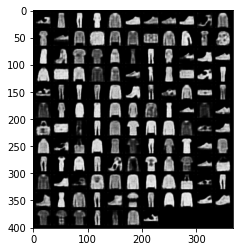

Loss 0.2566 (0.2821)
EPOCH: 3
TRAIN
Loss 0.2942 (0.2942)	
Loss 0.2837 (0.2814)	
Loss 0.2702 (0.2807)	
Loss 0.2883 (0.2798)	
Loss 0.2749 (0.2791)	
VALIDATION
Original images


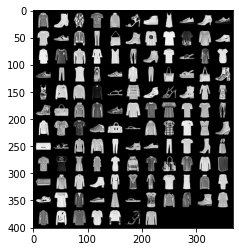

Reconstructed images


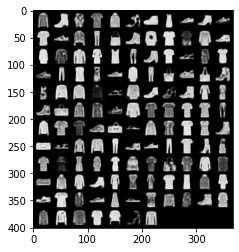

Loss 0.2718 (0.2759)
EPOCH: 4
TRAIN
Loss 0.2797 (0.2797)	
Loss 0.2872 (0.2758)	
Loss 0.2683 (0.2750)	
Loss 0.2873 (0.2746)	
Loss 0.2604 (0.2743)	
VALIDATION
Original images


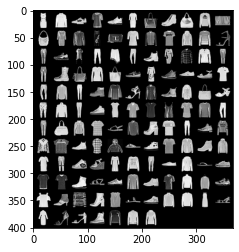

Reconstructed images


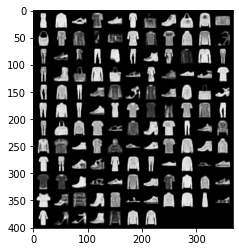

Loss 0.2593 (0.2720)
EPOCH: 5
TRAIN
Loss 0.2631 (0.2631)	
Loss 0.2639 (0.2715)	
Loss 0.2741 (0.2723)	
Loss 0.2596 (0.2715)	
Loss 0.2805 (0.2710)	
VALIDATION
Original images


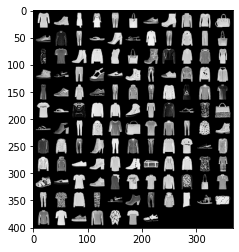

Reconstructed images


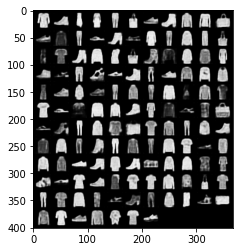

Loss 0.2788 (0.2699)
EPOCH: 6
TRAIN
Loss 0.2716 (0.2716)	
Loss 0.2713 (0.2703)	
Loss 0.2811 (0.2691)	
Loss 0.2692 (0.2687)	
Loss 0.2626 (0.2689)	
VALIDATION
Original images


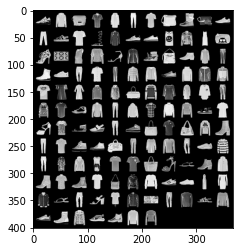

Reconstructed images


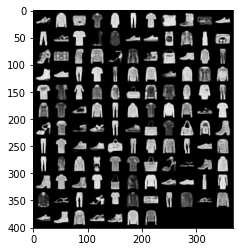

Loss 0.2518 (0.2680)
EPOCH: 7
TRAIN
Loss 0.2878 (0.2878)	
Loss 0.2628 (0.2679)	
Loss 0.2615 (0.2670)	
Loss 0.2566 (0.2667)	
Loss 0.2799 (0.2672)	
VALIDATION
Original images


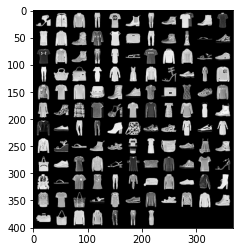

Reconstructed images


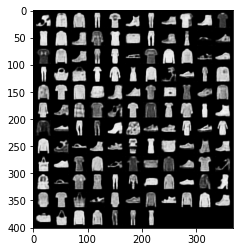

Loss 0.2573 (0.2667)
EPOCH: 8
TRAIN
Loss 0.2702 (0.2702)	
Loss 0.2823 (0.2667)	
Loss 0.2652 (0.2659)	
Loss 0.2560 (0.2660)	
Loss 0.2597 (0.2659)	
VALIDATION
Original images


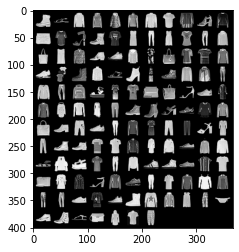

Reconstructed images


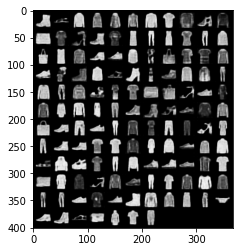

Loss 0.2700 (0.2652)
EPOCH: 9
TRAIN
Loss 0.2614 (0.2614)	
Loss 0.2561 (0.2648)	
Loss 0.2640 (0.2651)	
Loss 0.2606 (0.2648)	
Loss 0.2618 (0.2652)	
VALIDATION
Original images


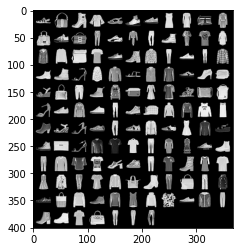

Reconstructed images


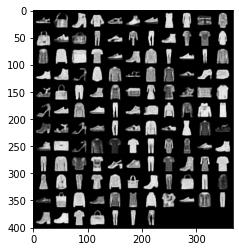

Loss 0.2963 (0.2641)
EPOCH: 10
TRAIN
Loss 0.2686 (0.2686)	
Loss 0.2655 (0.2640)	
Loss 0.2707 (0.2644)	
Loss 0.2673 (0.2642)	
Loss 0.2702 (0.2640)	
VALIDATION
Original images


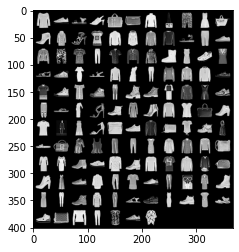

Reconstructed images


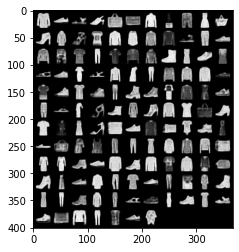

Loss 0.3123 (0.2635)
EPOCH: 11
TRAIN
Loss 0.2683 (0.2683)	
Loss 0.2668 (0.2633)	
Loss 0.2665 (0.2629)	
Loss 0.2528 (0.2632)	
Loss 0.2684 (0.2630)	
VALIDATION
Original images


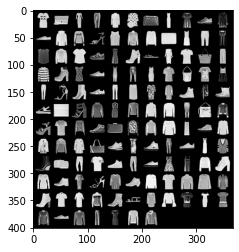

Reconstructed images


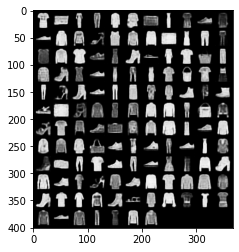

Loss 0.2633 (0.2629)
EPOCH: 12
TRAIN
Loss 0.2759 (0.2759)	
Loss 0.2593 (0.2624)	
Loss 0.2623 (0.2628)	
Loss 0.2637 (0.2626)	
Loss 0.2601 (0.2625)	
VALIDATION
Original images


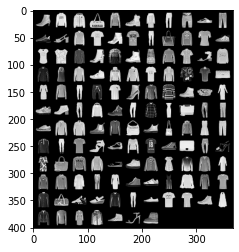

Reconstructed images


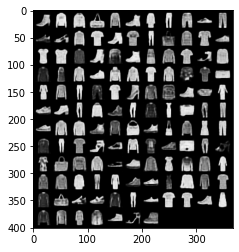

Loss 0.2710 (0.2619)
EPOCH: 13
TRAIN
Loss 0.2679 (0.2679)	
Loss 0.2688 (0.2624)	
Loss 0.2666 (0.2628)	
Loss 0.2623 (0.2620)	
Loss 0.2557 (0.2616)	
VALIDATION
Original images


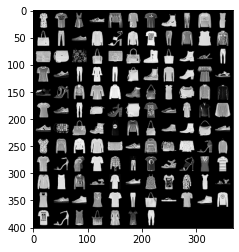

Reconstructed images


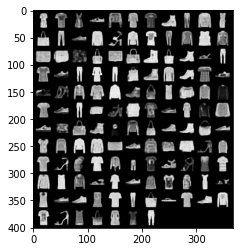

Loss 0.2851 (0.2617)
EPOCH: 14
TRAIN
Loss 0.2726 (0.2726)	
Loss 0.2579 (0.2622)	
Loss 0.2617 (0.2618)	
Loss 0.2694 (0.2614)	
Loss 0.2690 (0.2615)	
VALIDATION
Original images


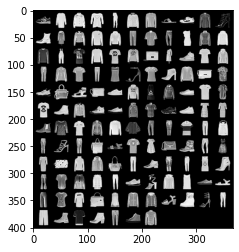

Reconstructed images


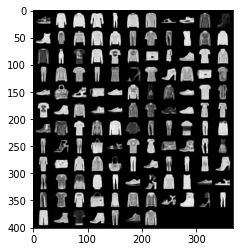

Loss 0.2704 (0.2609)
EPOCH: 15
TRAIN
Loss 0.2455 (0.2455)	
Loss 0.2521 (0.2604)	
Loss 0.2613 (0.2606)	
Loss 0.2553 (0.2608)	
Loss 0.2705 (0.2609)	
VALIDATION
Original images


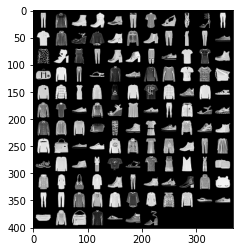

Reconstructed images


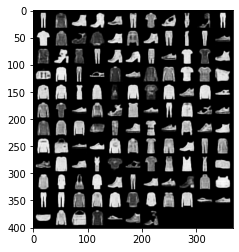

Loss 0.2800 (0.2608)
EPOCH: 16
TRAIN
Loss 0.2606 (0.2606)	
Loss 0.2567 (0.2601)	
Loss 0.2610 (0.2604)	
Loss 0.2595 (0.2603)	
Loss 0.2456 (0.2603)	
VALIDATION
Original images


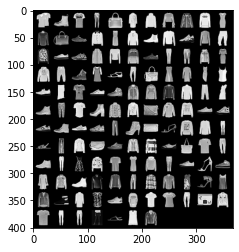

Reconstructed images


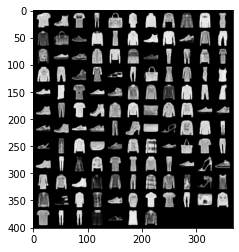

Loss 0.2721 (0.2600)
EPOCH: 17
TRAIN
Loss 0.2643 (0.2643)	
Loss 0.2570 (0.2600)	
Loss 0.2661 (0.2597)	
Loss 0.2720 (0.2598)	
Loss 0.2556 (0.2599)	
VALIDATION
Original images


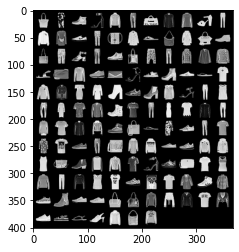

Reconstructed images


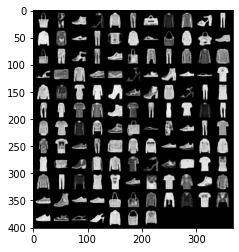

Loss 0.2703 (0.2598)
EPOCH: 18
TRAIN
Loss 0.2692 (0.2692)	
Loss 0.2653 (0.2592)	
Loss 0.2518 (0.2594)	
Loss 0.2599 (0.2596)	
Loss 0.2505 (0.2598)	
VALIDATION
Original images


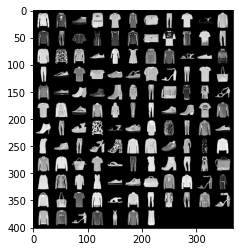

Reconstructed images


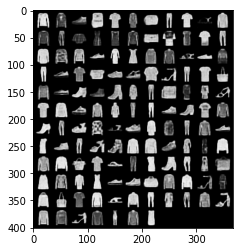

Loss 0.1945 (0.2595)
EPOCH: 19
TRAIN
Loss 0.2669 (0.2669)	
Loss 0.2643 (0.2602)	
Loss 0.2543 (0.2600)	
Loss 0.2405 (0.2591)	
Loss 0.2615 (0.2594)	
VALIDATION
Original images


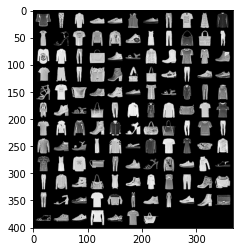

Reconstructed images


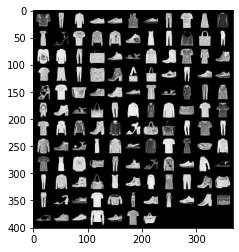

Loss 0.2337 (0.2598)
EPOCH: 20
TRAIN
Loss 0.2619 (0.2619)	
Loss 0.2691 (0.2586)	
Loss 0.2541 (0.2592)	
Loss 0.2526 (0.2593)	
Loss 0.2578 (0.2590)	
VALIDATION
Original images


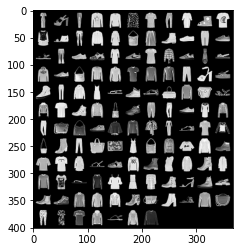

Reconstructed images


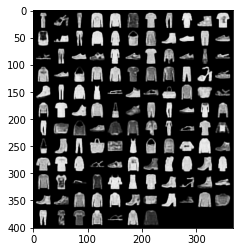

Loss 0.2125 (0.2590)


In [15]:
# create an instance of the MLP based autoencoder and transfer the model to the device.
# Note that we do not necessarily need any custom weight initialization as PyTorch
# already uses the initialization schemes that we have previously learned about internally. 
CNN_AE_model = AE_CNN().to(device)
# we can also print the model architecture
print(CNN_AE_model)

# set the loss function
criterion = nn.BCEWithLogitsLoss().to(device)

# we can use advanced stochastic gradient descent algorithms 
# with regularization (weight-decay) or momentum
optimizer = torch.optim.Adam(CNN_AE_model.parameters(), lr=1e-4)

total_epochs = 20
for epoch in range(total_epochs):
    print("EPOCH:", epoch + 1)
    print("TRAIN")
    train(dataset.train_loader, CNN_AE_model, criterion, optimizer, device)
    print("VALIDATION")
    validate(dataset.val_loader, CNN_AE_model, criterion, device)

We can observe that already our first epoch achieves a better loss and qualitatively better looking reconstructed images in the convolutional neural network autoencoder variant.

As this encoding seems to be much better, we can ask ourselves the question whether our semi-supervised learning approach will fare much better now. This is something that you should try to get a better feeling for the learned representations. 



# Variational Autoencoder
We have seen how we can encode data into a latent vector and decode back to the original image for training with reconstruction loss.  

In the lecture we have encountered another Bayesian variant, called the variational autoencoder that provides a different perspective with a powerful generative model: https://arxiv.org/abs/1312.6114 . 
We will now minimize the variational lower bound on the evidence (ELBO). To approximate the true posterior to the generative model p(x, z) we will use our neural network encoder to calculate q(x|z) (the approximate posterior). This is sometimes also referred to as the recognition model.

The probabilistic decoder p(x|z) in turn computes the probability density of an input x under the generative model given a sample z from the approximate posterior q(z|x). Like in the autoencoder the parameters of encoder and decoder are optimized jointly. 

We can conduct this optimization using the reparameterization trick, where we express the random variable z through a deterministic variable as seen in the lecture.

In practical terms, in contrast to the regular autoencoder, we thus now optimize for both a reconstruction loss and KL divergence between our prior and approximate posterior. 

Following the lecture, we will use a Gaussian prior and implement the corresponding reparameterization.

A good in-depth introduction to variational auto-encoders for further reading can be found here: https://arxiv.org/abs/1906.02691

## Building our CNN model
Last week we have implemented our PyTorch models with nn.Sequential() containers in order to easily access the model.encoder to train a classifier on top. Prior to that we have seen how we can define our model's layers in the class' constructor and use a forward function to define the execution. This week we will encounter another third variant, where we define multiple custom functions called encode, decode and reparameterize which we can then individually access and define a joint forward function. 

In [16]:
class VAE_CNN(nn.Module):
    def __init__(self, latent_dim):
        super(VAE_CNN, self).__init__()
        
        self.latent_dim = latent_dim 
        
        self.conv1 = nn.Conv2d(1, 64, 5) # input features, output features, kernel size
        self.mp1 = nn.MaxPool2d(2, 2) # kernel size, stride
        
        self.conv2 = nn.Conv2d(64, 128, 5) # input features, output features, kernel size
        self.mp2 = nn.MaxPool2d(2, 2) # kernel size, stride
        
        # 4x4 is the remaining spatial resolution here
        self.latent_mu = nn.Linear(128*4*4, latent_dim) 
        self.latent_sigma = nn.Linear(128*4*4, latent_dim)
        
        # decoder layers
        self.latent_decode = nn.Linear(latent_dim, 128*4*4)
        self.tconv2 = nn.ConvTranspose2d(128, 64, 5)
        self.tconv1 = nn.ConvTranspose2d(64, 1, 5)
        
        self.Upsample = nn.Upsample(scale_factor=2, mode='nearest')
        
    def encode(self, x):
        # Conv + ReLU + max pooling for two layers
        x = self.mp1(F.relu(self.conv1(x)))
        x = self.mp2(F.relu(self.conv2(x)))
        # The view flattens the output to a vector (the representation needed by the classifier)
        x = x.view(x.size(0), -1)
        mu = self.latent_mu(x)
        sigma = self.latent_sigma(x)
        return mu, sigma
        
    def reparameterize(self, mu, std):
        # reparameterization: z = eps * sigma + mu
        # where eps ~ N(0, 1)
        eps = std.data.new(std.size()).normal_()
        z = eps.mul(std).add(mu)
        return z
    
    def decode(self, z):
        x = self.latent_decode(z)
        x = x.view(-1, 128, 4, 4)
        x = self.Upsample(x)
        x = self.Upsample(F.relu(self.tconv2(x)))
        x = self.tconv1(x)
        return x
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        z = self.reparameterize(mu, sigma)
        x = self.decode(z)
        return x, mu, sigma

#### We will now also have to define our loss function
In addition to the reconstruction loss, we need to implement the KL divergence between the approximate posterior, thus our latent mu and sigma and our unit Gaussian prior. 

We extend our loss function

In [17]:
def VAE_loss_function(output, target, mu, std):
    recon_loss_func = nn.BCEWithLogitsLoss(reduction='sum')

    # compute reconstruction loss - normalize by batch size
    recon_loss = recon_loss_func(output, target) / output.size(0)
    
    # numerical value for stability of log computation
    eps = 1e-8
    # compute Kullback Leibler Divergence - normalize by batch size
    kld = -0.5 * torch.sum(1 + torch.log(eps + std ** 2) - (mu ** 2) - (std ** 2)) / output.size(0)
    
    return recon_loss, kld

We will also need to modify our training and validation functions to include the modified loss and let the model return our latent mu and sigma vectors

In [18]:
def train_VAE(train_loader, model, criterion, optimizer, device):
    """
    Trains/updates the model for one epoch on the training dataset.

    Parameters:
        train_loader (torch.utils.data.DataLoader): The trainset dataloader
        model (torch.nn.module): Model to be trained
        criterion (torch.nn.criterion): Loss function
        optimizer (torch.optim.optimizer): optimizer instance like SGD or Adam
        device (string): cuda or cpu
    """

    # create an instance of the average meter to track losses
    losses = AverageMeter()
    recon_losses = AverageMeter()
    kl_losses = AverageMeter()

    # switch to train mode
    model.train()

    # iterate through the dataset loader
    # we can now discard the labels returned by our old data loader as we no longer need them
    for i, (inp, _) in enumerate(train_loader):
        # transfer inputs and targets to the GPU (if it is available)
        inp = inp.to(device)
        target = inp
        
        # you can make your autoencoder a denoising autoencoder by 
        # adding noise to the input, but not to the target!
        # To test the denoising autoencoder, uncomment the line below, 
        # where we add a small Gaussian noise to the original images
        #inp = inp + torch.randn(inp.size()).to(device) * 0.1
        
        # compute output, i.e. the model forward. 
        # In contrast to our autoencoder this now also returns the latent mu
        # and sigma that we need to calculate the KL divergence
        output, latent_mu, latent_sigma = model(inp)
        
        # calculate the loss
        recon_loss, kl_loss = criterion(output, target, latent_mu, latent_sigma)
        loss = recon_loss + kl_loss

        # record loss
        losses.update(loss.item(), inp.size(0))
        recon_losses.update(recon_loss.item(), inp.size(0))
        kl_losses.update(kl_loss.item(), inp.size(0))

        # compute gradient and do the SGD step
        # we reset the optimizer with zero_grad to "flush" former gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print the loss every 100 mini-batches
        if i % 100 == 0:
            print('Loss {loss.val:.4f} ({loss.avg:.4f}) \t'
                  'Reconstruction {recon.val:.4f} ({recon.avg:.4f}) \t'
                  'KLD {kld.val:.4f} ({kld.avg:.4f})'
                  .format(loss=losses, recon=recon_losses, kld=kl_losses))

In [19]:
def validate_VAE(val_loader, model, criterion, device):
    """
    Trains/updates the model for one epoch on the training dataset.

    Parameters:
        val_loader (torch.utils.data.DataLoader): The valset dataloader
        model (torch.nn.module): Model to be trained
        criterion (torch.nn.criterion): Loss function
        device (string): cuda or cpu
    """

    # create an instance of the average meter to track losses
    losses = AverageMeter()
    recon_losses = AverageMeter()
    kl_losses = AverageMeter()

    # switch to train mode
    model.eval()

    # iterate through the dataset loader
    # we can now discard the labels returned by our old data loader as we no longer need them
    for i, (inp, _) in enumerate(val_loader):
        # transfer inputs and targets to the GPU (if it is available)
        inp = inp.to(device)
        target = inp
        
        # compute output, i.e. the model forward. 
        # In contrast to our autoencoder this now also returns the latent mu
        # and sigma that we need to calculate the KL divergence
        output, latent_mu, latent_sigma = model(inp)
        
        # calculate the loss
        recon_loss, kl_loss = criterion(output, target, latent_mu, latent_sigma)
        loss = recon_loss + kl_loss

        # record loss
        losses.update(loss.item(), inp.size(0))
        recon_losses.update(recon_loss.item(), inp.size(0))
        kl_losses.update(kl_loss.item(), inp.size(0))
        
        # print the loss every 100 mini-batches
        if i % 100 == 0:
            print('Loss {loss.val:.4f} ({loss.avg:.4f}) \t'
                  'Reconstruction {recon.val:.4f} ({recon.avg:.4f}) \t'
                  'KLD {kld.val:.4f} ({kld.avg:.4f})'
                  .format(loss=losses, recon=recon_losses, kld=kl_losses))

In addition to training and validation, we can now also write a generation function. Once the model is training and minimizing the divergence between our approximate posterior distribution and our Gaussian prior, we can start sampling from the prior and directly generate images from the corresponding latent vector z. 

In [20]:
def generate(model, device, num_images=100):
    with torch.no_grad():
        # sample from the Gaussian prior p(z)
        z = torch.randn(num_images, model.latent_dim).to(device)

        # decode the samples p(x|z)
        # we add a sigmoid function at the end of the decoder to constrain 
        # the generated image to 0-1 range (which is otherwise not guaranteed)
        generated_images = torch.sigmoid(model.decode(z))

        # visualize
        imgs = torchvision.utils.make_grid(generated_images.cpu(),
                                           nrow=int(math.sqrt(generated_images.size(0))),
                                           padding=5)
        npimgs = imgs.numpy()
        # when using matplotlib the color channels are expected to be in the third 
        # instead of the first dimension -> tranpose
        plt.imshow(np.transpose(npimgs, (1,2,0)))
        plt.show()

### Constructing and running the CNN based VAE
Let's create an instance of our VAE model and optimize it. After each epoch we will sample from the prior and generate some example images and took a look at their visual quality.

VAE_CNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (latent_mu): Linear(in_features=2048, out_features=50, bias=True)
  (latent_sigma): Linear(in_features=2048, out_features=50, bias=True)
  (latent_decode): Linear(in_features=50, out_features=2048, bias=True)
  (tconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
  (tconv1): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(1, 1))
  (Upsample): Upsample(scale_factor=2.0, mode=nearest)
)
EPOCH: 1
TRAIN
Loss 701.9672 (701.9672) 	Reconstruction 556.4214 (556.4214) 	KLD 145.5458 (145.5458)
Loss 349.5875 (432.3668) 	Reconstruction 326.0758 (405.2294) 	KLD 23.5117 (27.1374)
Loss 312.9763 (378.9546) 	Reconstruction 288.1462 (353.3806) 	KLD 24.8301 (25.5741)
Loss 301.0579 (353.914

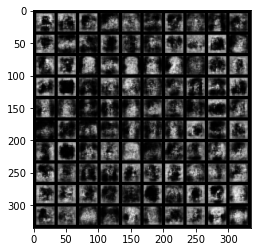

EPOCH: 2
TRAIN
Loss 288.2906 (288.2906) 	Reconstruction 264.9949 (264.9949) 	KLD 23.2956 (23.2956)
Loss 274.3852 (284.8928) 	Reconstruction 250.8312 (262.3364) 	KLD 23.5540 (22.5564)
Loss 281.4240 (283.6737) 	Reconstruction 259.4160 (261.3823) 	KLD 22.0080 (22.2913)
Loss 277.1425 (281.7448) 	Reconstruction 255.1318 (259.6526) 	KLD 22.0107 (22.0922)
Loss 285.6191 (280.3184) 	Reconstruction 263.9667 (258.3870) 	KLD 21.6524 (21.9314)
VALIDATION
Loss 269.5429 (269.5429) 	Reconstruction 249.1911 (249.1911) 	KLD 20.3519 (20.3519)
GENERATION


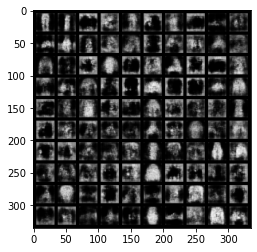

EPOCH: 3
TRAIN
Loss 274.8603 (274.8603) 	Reconstruction 254.0972 (254.0972) 	KLD 20.7631 (20.7631)
Loss 265.7343 (272.0505) 	Reconstruction 244.9203 (251.1874) 	KLD 20.8141 (20.8631)
Loss 276.1981 (271.4674) 	Reconstruction 256.1528 (250.7900) 	KLD 20.0453 (20.6774)
Loss 266.3698 (270.4611) 	Reconstruction 245.9722 (249.9382) 	KLD 20.3976 (20.5229)
Loss 274.7992 (269.6250) 	Reconstruction 254.1642 (249.2415) 	KLD 20.6350 (20.3835)
VALIDATION
Loss 268.1811 (268.1811) 	Reconstruction 249.2469 (249.2469) 	KLD 18.9341 (18.9341)
GENERATION


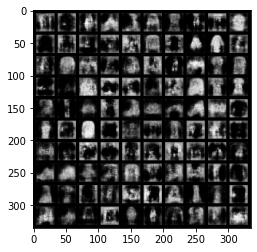

EPOCH: 4
TRAIN
Loss 265.3612 (265.3612) 	Reconstruction 245.4376 (245.4376) 	KLD 19.9237 (19.9237)
Loss 268.0116 (264.9883) 	Reconstruction 248.0557 (245.2744) 	KLD 19.9559 (19.7139)
Loss 271.5552 (264.4479) 	Reconstruction 252.8799 (244.9370) 	KLD 18.6753 (19.5109)
Loss 256.9601 (264.2568) 	Reconstruction 238.3192 (244.8937) 	KLD 18.6409 (19.3630)
Loss 255.7446 (263.7832) 	Reconstruction 237.7710 (244.5617) 	KLD 17.9735 (19.2215)
VALIDATION
Loss 260.1050 (260.1050) 	Reconstruction 242.0107 (242.0107) 	KLD 18.0944 (18.0944)
GENERATION


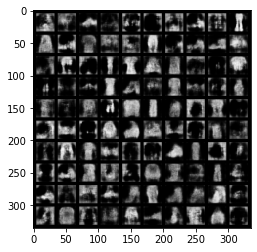

EPOCH: 5
TRAIN
Loss 262.6109 (262.6109) 	Reconstruction 244.0685 (244.0685) 	KLD 18.5424 (18.5424)
Loss 275.0457 (260.5227) 	Reconstruction 256.5223 (241.9070) 	KLD 18.5233 (18.6157)
Loss 250.4077 (259.6652) 	Reconstruction 232.5967 (241.1208) 	KLD 17.8109 (18.5444)
Loss 255.1277 (259.2759) 	Reconstruction 236.8928 (240.8191) 	KLD 18.2349 (18.4568)
Loss 265.0315 (259.3267) 	Reconstruction 247.0818 (240.9191) 	KLD 17.9497 (18.4076)
VALIDATION
Loss 266.9126 (266.9126) 	Reconstruction 249.5546 (249.5546) 	KLD 17.3580 (17.3580)
GENERATION


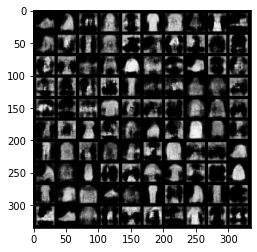

EPOCH: 6
TRAIN
Loss 257.2947 (257.2947) 	Reconstruction 240.1366 (240.1366) 	KLD 17.1581 (17.1581)
Loss 253.7879 (257.5470) 	Reconstruction 235.5483 (239.4696) 	KLD 18.2396 (18.0774)
Loss 260.2187 (256.9876) 	Reconstruction 241.6367 (238.9455) 	KLD 18.5820 (18.0421)
Loss 267.4118 (256.6979) 	Reconstruction 249.8175 (238.7114) 	KLD 17.5943 (17.9866)
Loss 258.1502 (256.3573) 	Reconstruction 240.8368 (238.4384) 	KLD 17.3134 (17.9190)
VALIDATION
Loss 256.6866 (256.6866) 	Reconstruction 238.2801 (238.2801) 	KLD 18.4066 (18.4066)
GENERATION


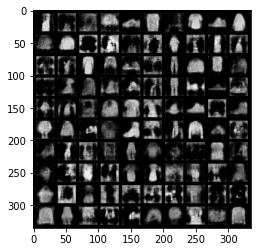

EPOCH: 7
TRAIN
Loss 261.9784 (261.9784) 	Reconstruction 244.1904 (244.1904) 	KLD 17.7880 (17.7880)
Loss 262.0460 (256.1609) 	Reconstruction 243.8353 (238.3121) 	KLD 18.2107 (17.8488)
Loss 253.5671 (255.5314) 	Reconstruction 235.7621 (237.8178) 	KLD 17.8050 (17.7137)
Loss 245.8233 (254.8946) 	Reconstruction 228.5316 (237.2369) 	KLD 17.2917 (17.6578)
Loss 258.4016 (254.4245) 	Reconstruction 240.1984 (236.7906) 	KLD 18.2032 (17.6339)
VALIDATION
Loss 242.5906 (242.5906) 	Reconstruction 225.4815 (225.4815) 	KLD 17.1091 (17.1091)
GENERATION


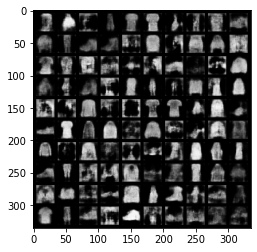

EPOCH: 8
TRAIN
Loss 256.3441 (256.3441) 	Reconstruction 238.6695 (238.6695) 	KLD 17.6746 (17.6746)
Loss 260.7668 (252.6154) 	Reconstruction 243.5491 (235.0814) 	KLD 17.2176 (17.5340)
Loss 254.5682 (252.7050) 	Reconstruction 237.6791 (235.1903) 	KLD 16.8891 (17.5147)
Loss 247.9110 (252.7636) 	Reconstruction 230.1494 (235.2420) 	KLD 17.7617 (17.5216)
Loss 244.9957 (252.6131) 	Reconstruction 227.1104 (235.1289) 	KLD 17.8853 (17.4842)
VALIDATION
Loss 244.8533 (244.8533) 	Reconstruction 227.1463 (227.1463) 	KLD 17.7070 (17.7070)
GENERATION


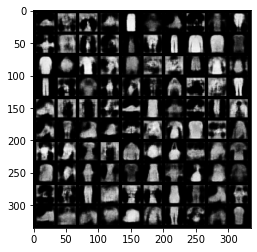

EPOCH: 9
TRAIN
Loss 253.0757 (253.0757) 	Reconstruction 235.6506 (235.6506) 	KLD 17.4252 (17.4252)
Loss 248.2229 (251.5286) 	Reconstruction 229.9738 (234.1844) 	KLD 18.2491 (17.3442)
Loss 250.8736 (251.8593) 	Reconstruction 233.8680 (234.5334) 	KLD 17.0056 (17.3259)
Loss 253.4483 (251.3731) 	Reconstruction 235.5433 (234.0755) 	KLD 17.9049 (17.2977)
Loss 244.5044 (251.3235) 	Reconstruction 227.2762 (234.0245) 	KLD 17.2282 (17.2990)
VALIDATION
Loss 247.5692 (247.5692) 	Reconstruction 230.5014 (230.5014) 	KLD 17.0678 (17.0678)
GENERATION


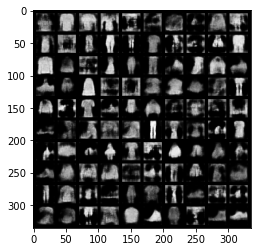

EPOCH: 10
TRAIN
Loss 246.4527 (246.4527) 	Reconstruction 229.5767 (229.5767) 	KLD 16.8760 (16.8760)
Loss 252.0344 (251.7022) 	Reconstruction 234.6724 (234.5262) 	KLD 17.3620 (17.1760)
Loss 241.9368 (250.5655) 	Reconstruction 222.7147 (233.3591) 	KLD 19.2221 (17.2064)
Loss 259.0487 (250.5254) 	Reconstruction 241.2527 (233.2590) 	KLD 17.7960 (17.2663)
Loss 252.0071 (250.5466) 	Reconstruction 234.5713 (233.2671) 	KLD 17.4359 (17.2795)
VALIDATION
Loss 240.1717 (240.1717) 	Reconstruction 222.7767 (222.7767) 	KLD 17.3950 (17.3950)
GENERATION


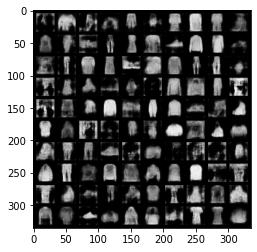

EPOCH: 11
TRAIN
Loss 253.6505 (253.6505) 	Reconstruction 236.3423 (236.3423) 	KLD 17.3081 (17.3081)
Loss 246.5332 (250.5833) 	Reconstruction 229.5347 (233.3239) 	KLD 16.9985 (17.2594)
Loss 244.1045 (249.8786) 	Reconstruction 226.3210 (232.6404) 	KLD 17.7835 (17.2382)
Loss 244.0179 (249.8592) 	Reconstruction 226.8033 (232.6129) 	KLD 17.2145 (17.2463)
Loss 246.2210 (249.4285) 	Reconstruction 228.9761 (232.1814) 	KLD 17.2449 (17.2471)
VALIDATION
Loss 248.6753 (248.6753) 	Reconstruction 230.6526 (230.6526) 	KLD 18.0227 (18.0227)
GENERATION


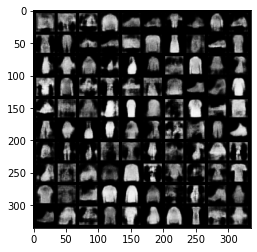

EPOCH: 12
TRAIN
Loss 248.2991 (248.2991) 	Reconstruction 230.5758 (230.5758) 	KLD 17.7233 (17.7233)
Loss 233.5979 (248.4004) 	Reconstruction 216.0112 (231.2692) 	KLD 17.5867 (17.1312)
Loss 253.8300 (248.1769) 	Reconstruction 236.5757 (231.0121) 	KLD 17.2542 (17.1648)
Loss 252.9983 (247.8223) 	Reconstruction 236.4170 (230.7056) 	KLD 16.5813 (17.1167)
Loss 252.9576 (248.2940) 	Reconstruction 236.1826 (231.1825) 	KLD 16.7750 (17.1115)
VALIDATION
Loss 242.7481 (242.7481) 	Reconstruction 225.9033 (225.9033) 	KLD 16.8448 (16.8448)
GENERATION


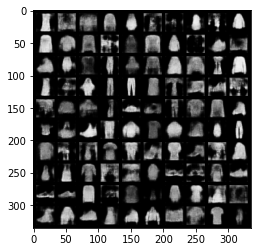

EPOCH: 13
TRAIN
Loss 247.1419 (247.1419) 	Reconstruction 229.6907 (229.6907) 	KLD 17.4512 (17.4512)
Loss 249.5702 (248.3679) 	Reconstruction 232.1957 (231.3074) 	KLD 17.3745 (17.0605)
Loss 236.7180 (247.9477) 	Reconstruction 220.5896 (230.8767) 	KLD 16.1285 (17.0710)
Loss 250.2025 (247.7664) 	Reconstruction 232.7994 (230.7287) 	KLD 17.4030 (17.0376)
Loss 253.0311 (247.7312) 	Reconstruction 236.1632 (230.7014) 	KLD 16.8679 (17.0297)
VALIDATION
Loss 250.8338 (250.8338) 	Reconstruction 233.8808 (233.8808) 	KLD 16.9531 (16.9531)
GENERATION


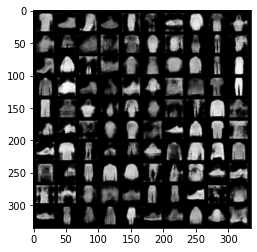

EPOCH: 14
TRAIN
Loss 242.4508 (242.4508) 	Reconstruction 225.2952 (225.2952) 	KLD 17.1556 (17.1556)
Loss 248.9314 (246.9559) 	Reconstruction 231.7930 (229.9032) 	KLD 17.1384 (17.0527)
Loss 246.1672 (247.2262) 	Reconstruction 228.7148 (230.1976) 	KLD 17.4524 (17.0286)
Loss 243.6824 (246.8463) 	Reconstruction 226.5299 (229.8794) 	KLD 17.1525 (16.9669)
Loss 238.8774 (246.8800) 	Reconstruction 221.9883 (229.9244) 	KLD 16.8891 (16.9556)
VALIDATION
Loss 248.7931 (248.7931) 	Reconstruction 232.1370 (232.1370) 	KLD 16.6561 (16.6561)
GENERATION


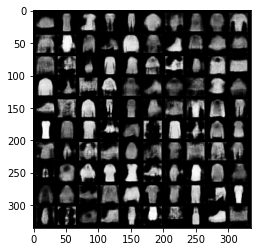

EPOCH: 15
TRAIN
Loss 248.6338 (248.6338) 	Reconstruction 231.7380 (231.7380) 	KLD 16.8958 (16.8958)
Loss 243.9968 (247.5535) 	Reconstruction 227.6810 (230.6372) 	KLD 16.3158 (16.9163)
Loss 235.5802 (246.9404) 	Reconstruction 219.1197 (230.0240) 	KLD 16.4605 (16.9164)
Loss 237.4532 (246.7286) 	Reconstruction 220.0013 (229.8029) 	KLD 17.4520 (16.9257)
Loss 248.1868 (246.6960) 	Reconstruction 231.3315 (229.7738) 	KLD 16.8553 (16.9221)
VALIDATION
Loss 249.5213 (249.5213) 	Reconstruction 233.4804 (233.4804) 	KLD 16.0410 (16.0410)
GENERATION


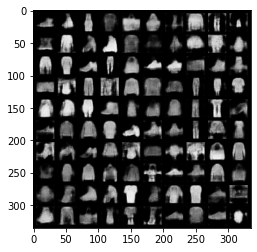

EPOCH: 16
TRAIN
Loss 245.5489 (245.5489) 	Reconstruction 228.4790 (228.4790) 	KLD 17.0699 (17.0699)
Loss 244.0784 (246.3444) 	Reconstruction 227.0038 (229.4376) 	KLD 17.0745 (16.9069)
Loss 239.2652 (246.2092) 	Reconstruction 222.2795 (229.2947) 	KLD 16.9857 (16.9145)
Loss 251.9841 (245.7805) 	Reconstruction 234.5955 (228.8489) 	KLD 17.3887 (16.9315)
Loss 247.0339 (245.9570) 	Reconstruction 229.2896 (229.0470) 	KLD 17.7443 (16.9100)
VALIDATION
Loss 242.8156 (242.8156) 	Reconstruction 226.2171 (226.2171) 	KLD 16.5985 (16.5985)
GENERATION


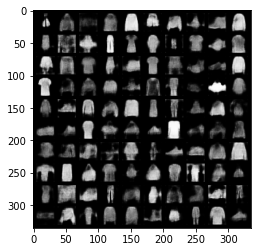

EPOCH: 17
TRAIN
Loss 242.3427 (242.3427) 	Reconstruction 225.1619 (225.1619) 	KLD 17.1808 (17.1808)
Loss 244.3503 (245.0101) 	Reconstruction 227.8101 (228.1586) 	KLD 16.5402 (16.8516)
Loss 240.4203 (245.2373) 	Reconstruction 223.0616 (228.3861) 	KLD 17.3587 (16.8512)
Loss 243.7984 (245.1909) 	Reconstruction 227.4541 (228.3181) 	KLD 16.3444 (16.8727)
Loss 247.1222 (245.4454) 	Reconstruction 230.1070 (228.5877) 	KLD 17.0153 (16.8577)
VALIDATION
Loss 233.9944 (233.9944) 	Reconstruction 217.7815 (217.7815) 	KLD 16.2129 (16.2129)
GENERATION


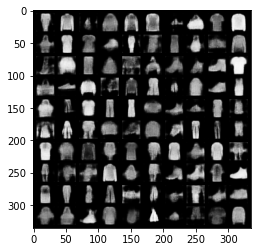

EPOCH: 18
TRAIN
Loss 256.9020 (256.9020) 	Reconstruction 239.6603 (239.6603) 	KLD 17.2417 (17.2417)
Loss 229.4591 (246.0703) 	Reconstruction 212.0352 (229.3257) 	KLD 17.4238 (16.7446)
Loss 244.7076 (246.2543) 	Reconstruction 227.7054 (229.4361) 	KLD 17.0021 (16.8182)
Loss 243.1269 (246.1376) 	Reconstruction 226.1581 (229.3268) 	KLD 16.9688 (16.8107)
Loss 232.4752 (245.8164) 	Reconstruction 215.6991 (229.0132) 	KLD 16.7761 (16.8032)
VALIDATION
Loss 240.4012 (240.4012) 	Reconstruction 223.7388 (223.7388) 	KLD 16.6625 (16.6625)
GENERATION


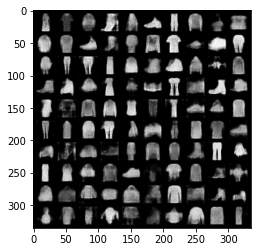

EPOCH: 19
TRAIN
Loss 248.8082 (248.8082) 	Reconstruction 232.5765 (232.5765) 	KLD 16.2316 (16.2316)
Loss 245.9282 (245.1887) 	Reconstruction 229.7951 (228.3331) 	KLD 16.1331 (16.8556)
Loss 251.2947 (244.1674) 	Reconstruction 234.2166 (227.3317) 	KLD 17.0781 (16.8357)
Loss 234.0384 (244.6109) 	Reconstruction 217.2211 (227.7851) 	KLD 16.8173 (16.8257)
Loss 242.3564 (244.6605) 	Reconstruction 225.3783 (227.8454) 	KLD 16.9782 (16.8151)
VALIDATION
Loss 248.8721 (248.8721) 	Reconstruction 232.3131 (232.3131) 	KLD 16.5590 (16.5590)
GENERATION


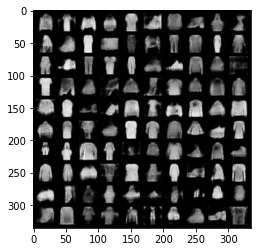

EPOCH: 20
TRAIN
Loss 241.9556 (241.9556) 	Reconstruction 224.8380 (224.8380) 	KLD 17.1177 (17.1177)
Loss 243.2810 (244.9503) 	Reconstruction 226.1479 (228.1766) 	KLD 17.1331 (16.7737)
Loss 259.3517 (244.4756) 	Reconstruction 243.2981 (227.6707) 	KLD 16.0536 (16.8049)
Loss 251.2026 (244.5496) 	Reconstruction 234.1320 (227.7594) 	KLD 17.0706 (16.7902)
Loss 238.9315 (244.6500) 	Reconstruction 222.2762 (227.8030) 	KLD 16.6553 (16.8470)
VALIDATION
Loss 251.8607 (251.8607) 	Reconstruction 234.7181 (234.7181) 	KLD 17.1426 (17.1426)
GENERATION


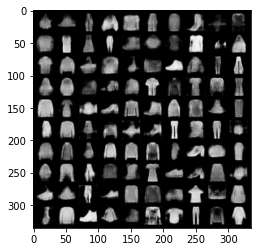

In [21]:
# create VAE model instance
latent_dim = 50 # like in the autoencoder, this is a hyper-parameter
# a good starting point for the above model is a latent dimension of 50.
model = VAE_CNN(latent_dim).to(device)
print(model)

# again, define loss function and optimizer. This time using our custom loss.
criterion = VAE_loss_function

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# optimize
total_epochs = 20
for epoch in range(total_epochs):
    print("EPOCH:", epoch + 1)
    print("TRAIN")
    train_VAE(dataset.train_loader, model, criterion, optimizer, device)
    print("VALIDATION")
    validate_VAE(dataset.val_loader, model, criterion, device)
    print("GENERATION")
    generate(model, device, num_images=100)

We can see that initially the samples do not look like the data from our training distribution, but after some epochs of optimizing the generative model we are able to generate images by decoding the samples from our Gaussian prior. 

# Additional (optional) exercises

Use a 2 dimensional latent space and visualize the latent space of the trained model as well as traverse deterministic z values during generation to see how the model interpolates between different concepts. 
